In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/journey-springfield.zip

In [6]:
TEST_DIR = Path('/content/testset')
TRAIN_DIR = Path('/content/train')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
TEST_DIR = Path('C:/Users/Vladimir/Documents/Py_works/Deep learning course/DL advanced course/journey-springfield/testset')
TRAIN_DIR = Path('C:/Users/Vladimir/Documents/Py_works/Deep learning course/DL advanced course/journey-springfield/train')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
#val_files[0]
train_files[0]

PosixPath('/content/train/simpsons_dataset/milhouse_van_houten/pic_0013.jpg')

In [10]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [13]:
# постоянные метки
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

labels = [path.parent.name for path in train_val_files]
lb = LabelEncoder().fit(labels)

with open('label_encoder.pkl', 'wb') as le_dump_file:
  pickle.dump(lb, le_dump_file)

In [11]:
class SimpsonsDataset2(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_a = transforms.Compose([
            #transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform = transforms.Compose([
            #transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        x = self.load_sample(self.files[index])


        if self.mode =='test':
            x = self._prepare_sample(x)
            x = transform(x)
            return x
        elif self.mode == 'val':
            x = self._prepare_sample(x)
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        else:
            x = transform_a(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

In [14]:
val_dataset2 = SimpsonsDataset2(val_files, mode='val')
    
train_dataset2 = SimpsonsDataset2(train_files, mode='train')

In [15]:
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import numpy as np
from tqdm import tqdm, trange

### Модель

In [ ]:
model_VGG16 = models.vgg16(pretrained=True)

In [17]:
model_VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
'''# замораживаем полностью
for param in model_extVGG.parameters():
    param.requires_grad = False

num_features = 4096

model_VGG16.classifier[6] = nn.Linear(num_features, 42)

model_VGG16 = model_VGG16.cuda()

# cost function
loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_VGG16.classifier.parameters(), lr=0.001, momentum=0.9)

# эвристика
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
# или разморозка
layers_to_unfreeze = 7

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_VGG16.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
num_features = 4096

model_VGG16.classifier[6] = nn.Linear(num_features, 42)

model_VGG16 = model_VGG16.cuda()

# cost function
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и классифаер
optimizer_ft = optim.SGD(list(model_VGG16.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_VGG16.classifier.parameters()), lr=0.001, momentum=0.9)


In [27]:
model_VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
def trainA(train_files, val_files, model, epochs, batch_size, optimizer, criterion):

    import copy
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = criterion

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # если достиглось лучшее качество, то запомним веса модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    print('Best val Acc: {:4f}'.format(best_acc))
            
    return history, model

In [22]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [23]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

обучаем

In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [28]:
%%time
epochs = 20
batch_size=64

historyVGG, model_VGG16 = trainA(train_dataset2, val_dataset2, model_VGG16, epochs, batch_size, optimizer_ft, loss_fn )

torch.save(model_VGG16.state_dict(), 'model_VGG16.pth')

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.9449776469677813


epoch:   5%|▌         | 1/20 [03:52<1:13:31, 232.21s/it]


Epoch 001 train_loss: 1.9450     val_loss 0.9349 train_acc 0.4810 val_acc 0.7482
loss 0.6727263565518778


epoch:  10%|█         | 2/20 [07:40<1:09:18, 231.00s/it]


Epoch 002 train_loss: 0.6727     val_loss 0.5861 train_acc 0.8179 val_acc 0.8473
loss 0.42611260434891574


epoch:  15%|█▌        | 3/20 [11:30<1:05:23, 230.77s/it]


Epoch 003 train_loss: 0.4261     val_loss 0.4752 train_acc 0.8846 val_acc 0.8745
loss 0.3050691748479421


epoch:  20%|██        | 4/20 [15:20<1:01:27, 230.47s/it]


Epoch 004 train_loss: 0.3051     val_loss 0.4155 train_acc 0.9151 val_acc 0.8873
loss 0.22847897948425389


epoch:  25%|██▌       | 5/20 [19:10<57:33, 230.25s/it]


Epoch 005 train_loss: 0.2285     val_loss 0.3922 train_acc 0.9372 val_acc 0.8951
loss 0.17774582059814395


epoch:  30%|███       | 6/20 [23:00<53:45, 230.41s/it]


Epoch 006 train_loss: 0.1777     val_loss 0.3652 train_acc 0.9512 val_acc 0.9024
loss 0.13412669941823765


epoch:  35%|███▌      | 7/20 [26:52<49:59, 230.77s/it]


Epoch 007 train_loss: 0.1341     val_loss 0.3549 train_acc 0.9622 val_acc 0.9085
loss 0.10607164231969549


epoch:  40%|████      | 8/20 [30:41<46:02, 230.22s/it]


Epoch 008 train_loss: 0.1061     val_loss 0.3744 train_acc 0.9692 val_acc 0.9037
loss 0.08834790167316231


epoch:  45%|████▌     | 9/20 [34:34<42:20, 230.94s/it]


Epoch 009 train_loss: 0.0883     val_loss 0.3406 train_acc 0.9750 val_acc 0.9131
loss 0.07158841919117148


epoch:  50%|█████     | 10/20 [38:27<38:37, 231.72s/it]


Epoch 010 train_loss: 0.0716     val_loss 0.4284 train_acc 0.9796 val_acc 0.8987


epoch:  50%|█████     | 10/20 [38:35<38:35, 231.57s/it]


KeyboardInterrupt: ignored

In [32]:
torch.save(model_VGG16.state_dict(), 'model_VGG16_10epoch.pth')

In [30]:
loss, acc, val_loss, val_acc = zip(*historyVGG)

NameError: ignored

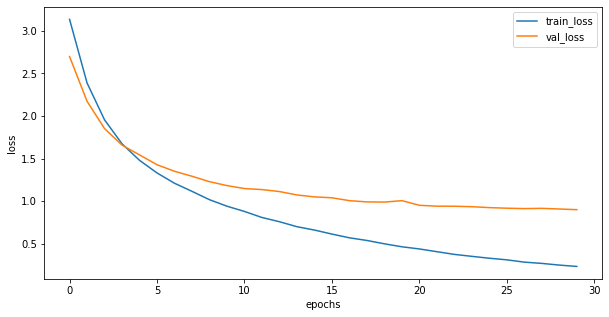

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Качество по классам

In [34]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [35]:
imgs = [val_dataset2[id][0].unsqueeze(0) for id in range(len(val_dataset2))]

actual_labels = [val_dataset2[id][1] for id in range(len(val_dataset2))]

probs_ims = predict(model_VGG16, imgs)
y_pred = np.argmax(probs_ims,-1)

In [36]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

print(classification_report(actual_labels, y_pred, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.97      0.89      0.93       228
           agnes_skinner       1.00      0.30      0.46        10
  apu_nahasapeemapetilon       0.92      0.93      0.93       156
           barney_gumble       0.89      0.62      0.73        26
            bart_simpson       0.95      0.95      0.95       336
            carl_carlson       0.91      0.88      0.89        24
charles_montgomery_burns       1.00      0.77      0.87       298
            chief_wiggum       0.90      0.96      0.93       247
         cletus_spuckler       0.90      0.75      0.82        12
          comic_book_guy       0.88      0.90      0.89       117
               disco_stu       0.00      0.00      0.00         2
          edna_krabappel       0.98      0.94      0.96       114
                fat_tony       1.00      0.86      0.92         7
                     gil       0.50      0.43      0.46         7
    groun

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
test_dataset = SimpsonsDataset2(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_VGG16, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [38]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [40]:
my_submit.to_csv('/content/drive/MyDrive/DLS advanced course/Simpson_competition/model_VGG16_10epoch.csv', index = False)